In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/jesse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jesse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Overview

### Read the Dataset

In [9]:
column_names = [
    'ID',                    # Column 1: ID of the statement
    'Label',                 # Column 2: Label
    'Statement',             # Column 3: Statement
    'Subject',               # Column 4: Subject(s)
    'Speaker',               # Column 5: Speaker
    'Speaker Job Title',     # Column 6: Speaker's Job Title
    'State Info',            # Column 7: State Info
    'Party Affiliation',     # Column 8: Party Affiliation
    'Barely True Counts',    # Column 9: Barely True Counts
    'False Counts',          # Column 10: False Counts
    'Half True Counts',      # Column 11: Half True Counts
    'Mostly True Counts',    # Column 12: Mostly True Counts
    'Pants on Fire Counts',  # Column 13: Pants on Fire Counts
    'Context'                # Column 14: Context (venue / location of the speech or statement)
]

In [10]:
def read_dataframe(tsv_file: str) -> pd.DataFrame :
    """
    Read data from table
    Pre-process missing value
    """
    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t')
    ## Numerical Filled missing values with 0
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)
    ## Categorical Filled missing values with an empty string
    string_columns = df.select_dtypes(include=['object']).columns
    df[string_columns] = df[string_columns].fillna("")
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = column_names
    return df

In [11]:
df_train = read_dataframe('train.tsv')

In [12]:
df_train.head()

,ID,Label,Statement,Subject,Speaker,Speaker Job Title,State Info,Party Affiliation,Barely True Counts,False Counts,Half True Counts,Mostly True Counts,Pants on Fire Counts,Context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10239 non-null  object 
 1   Label                 10239 non-null  object 
 2   Statement             10239 non-null  object 
 3   Subject               10239 non-null  object 
 4   Speaker               10239 non-null  object 
 5   Speaker Job Title     10239 non-null  object 
 6   State Info            10239 non-null  object 
 7   Party Affiliation     10239 non-null  object 
 8   Barely True Counts    10239 non-null  float64
 9   False Counts          10239 non-null  float64
 10  Half True Counts      10239 non-null  float64
 11  Mostly True Counts    10239 non-null  float64
 12  Pants on Fire Counts  10239 non-null  float64
 13  Context               10239 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [14]:
def show_news_article(input_df: pd.DataFrame, index: int) -> None:
    """
    Most relevant columns analysis
    
    Parameter
    ---------
    `index`: the row in original dataset
    """
    print(f"speaker: {input_df.iat[index, 4]}")
    print(f"subject(s): {input_df.iat[index, 3]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 1]}")

In [15]:
show_news_article(df_train, 1)

speaker: barack-obama
subject(s): foreign-policy
statement: Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
label: mostly-true


#### Statement Analysis

In [16]:
def plotbh(df, col):
    """Draw boxplot and histogram for numerical variables"""
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    # Boxplot
    sns.boxplot(x=df[col], ax=axs[0])
    axs[0].set_title('Box chart of ' + col)

    # Histogram
    sns.histplot(data=df, x=col, kde=True, ax=axs[1])
    axs[1].set_title('Histogram of ' + col)

    plt.tight_layout()
    plt.show()

In [17]:
df_train['statement_words'] = df_train['Statement'].apply(lambda x : len(x.split()))
df_train['statement_words'].describe()

count    10239.000000
mean        18.010743
std          9.658795
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max        467.000000
Name: statement_words, dtype: float64

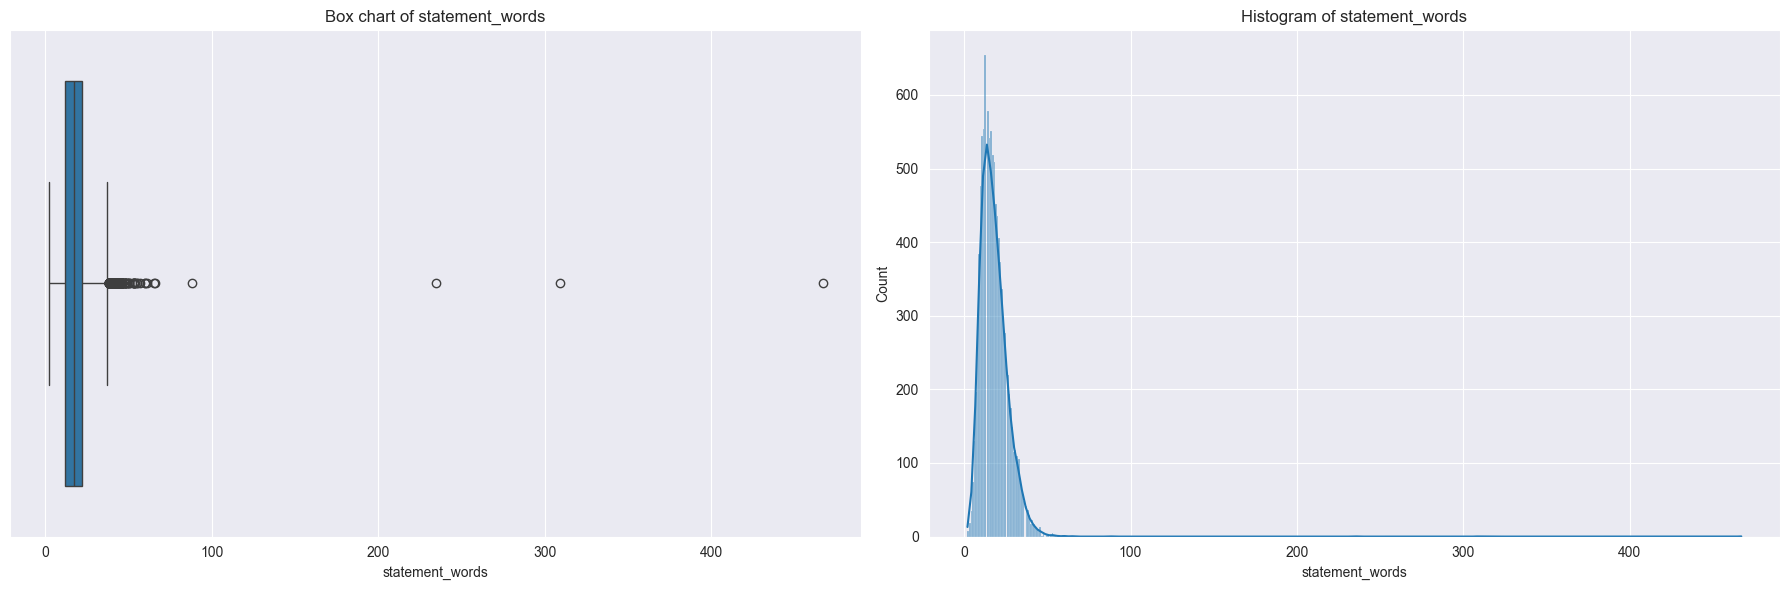

In [18]:
plotbh(df_train, 'statement_words')

In [19]:
# Get the list of English stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

# Define a function to clean and tokenize the statements
def clean_and_tokenize(statement):
    # Tokenize the statement
    statement_tokens = nltk.word_tokenize(statement)
    # Convert tokens to lowercase, remove stopwords, non-alphabetic characters, and punctuation
    cleaned_tokens = [
        statement_token.lower() for statement_token in statement_tokens 
            if statement_token.lower() not in stop_words and statement_token.isalpha()
    ]
    return cleaned_tokens

# Apply the cleaning and tokenization function to the 'Statement' column
df_train['word_token'] = df_train['Statement'].apply(clean_and_tokenize)

# Combine all cleaned tokens into one list of words
all_cleaned_words = df_train['word_token'].explode().tolist()

In [20]:
# Use Counter to count the frequency of each cleaned word
word_freq = Counter(all_cleaned_words)

# Convert to a DataFrame for easier analysis
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

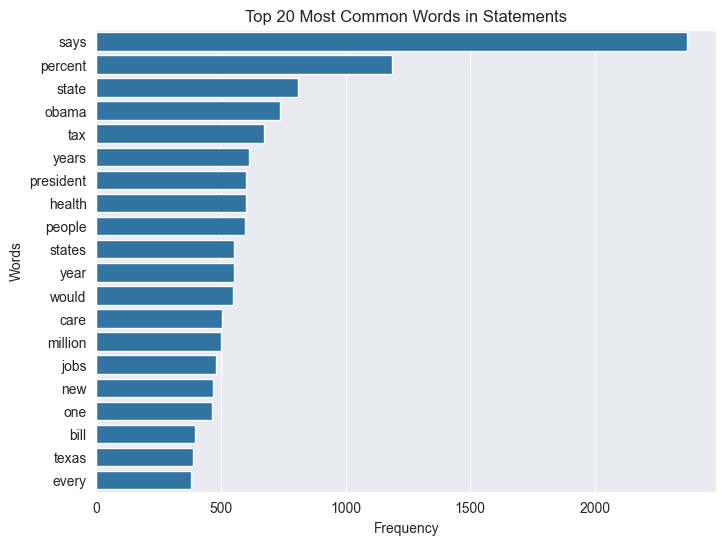

In [21]:
# Plot the most common words using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df.head(20))
plt.title('Top 20 Most Common Words in Statements')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

#### Label Analysis

Categorical label: ['half-true', 'mostly-true', 'false', 'true', 'barely-true', 'pants-fire']. They are in same column

Numerical label has separated columns, they are ['Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts']

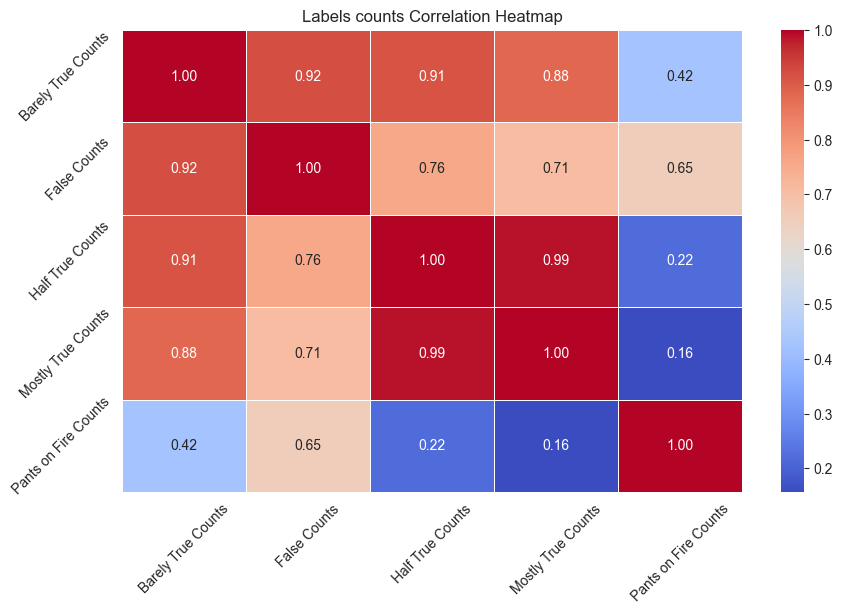

In [22]:
labels_count = ['Barely True Counts', 'False Counts', 'Half True Counts', 'Mostly True Counts', 'Pants on Fire Counts']

# Calculate the correlation matrix
correlation_matrix = df_train[labels_count].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Labels counts Correlation Heatmap')

plt.show()

This the numerical label of LIAR

The labels "Barely True," "False," "Half True," and "Mostly True" are highly correlated, suggesting that they often overlap or represent similar levels of truthfulness in statements.

"Pants on Fire" shows a weaker correlation with the other labels, indicating that it might capture a more extreme or different kind of falseness compared to the other categories.


Code idea comes from [Kaggle](https://www.kaggle.com/code/hendrixwilsonj/liar-data-analysis#Exporting-our-model)

The following analysis are based on the categorical label

In [23]:
def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:
    """
    Label distribution
    """
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['Label'].value_counts(normalize=True)
    
    def multiply_100(x):
        return x * 100
    
    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)
    
    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue', # true
    ]
    label_frequencies = label_frequencies.reindex(index = labels)
    
    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(8, 4), color=colors)
    axis.set_xlabel('Percentage')
    axis.set_title(f"Distribution of label values [{title}, sample_size={len(input_df)}]", size=10)

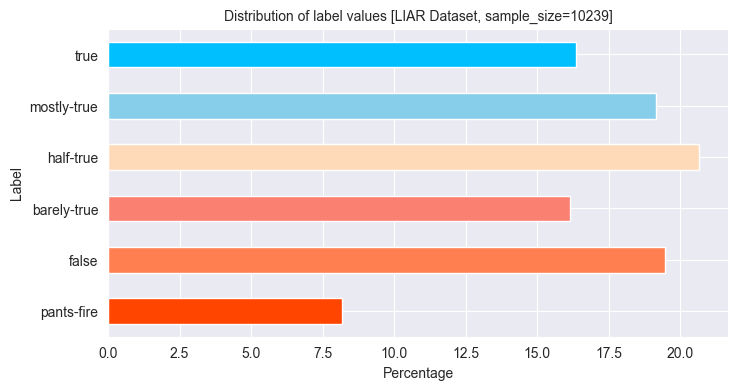

In [24]:
label_bar_chart(df_train)

#### Speaker Analysis

In [25]:
num_speakers = df_train['Speaker'].nunique()
avg_statments = len(df_train) / num_speakers

print(f"Unique speakers in dataset: {num_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 2910
Average statements made per speaker: 3.5185567010309278


In [26]:
speaker_lists = df_train['Speaker'].unique().tolist()
speaker_lists[:5]

['scott-surovell',
 'barack-obama',
 'blog-posting',
 'charlie-crist',
 'robin-vos']

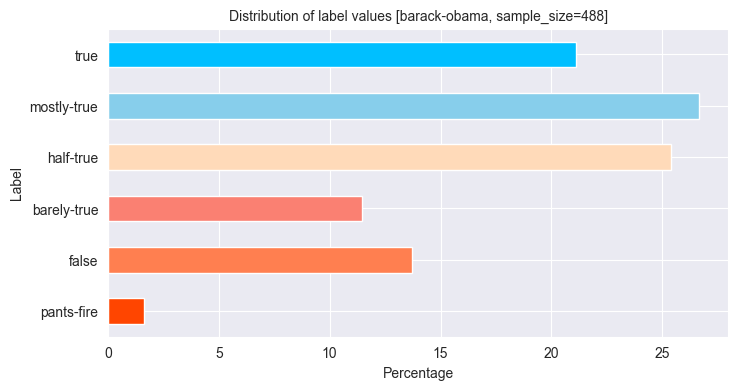

In [27]:
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:
    """
    Label distribution by Speaker
    """
    # filters the input_df
    speaker_df = input_df[ input_df['Speaker'] == speaker ]
    speaker_df.reset_index(inplace=True)
    
    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)
    
    return speaker_df
    

# create a bar chart over labels for a single speaker. Store the returned dataframe to a variable.
speak_ret_df = speaker_bar_chart(df_train, 'barack-obama')

#### Subject Analysis

In [28]:
# creates a new dataframe that only contains the label and subjects columns.
subject_df = df_train[['Label', 'Subject']].copy()


def csv_to_list(x):
    # start by turning the comma-separated values into a list of values
    return x.split(",")


subject_df['Subject'] = subject_df['Subject'].apply(csv_to_list)

subject_df = subject_df.explode('Subject')

subject_df.head()

,Label,Subject
0,half-true,energy
0,half-true,history
0,half-true,job-accomplishments
1,mostly-true,foreign-policy
2,false,health-care


In [29]:
num_unique_subjects = subject_df['Subject'].nunique()

print(f"Unique subjects in dataset: {num_unique_subjects}")

Unique subjects in dataset: 143


In [30]:
subject_lists = subject_df['Subject'].unique().tolist()
num = 5
print(f"{num} example subjects:")
subject_lists[:num]

5 example subjects:


['energy', 'history', 'job-accomplishments', 'foreign-policy', 'health-care']

In [31]:
def subject_bar_chart(input_df: pd.DataFrame, subject: str) -> pd.DataFrame:
    
    # filters the input_df
    ret_df = input_df[ input_df['Subject'] == subject ]
    ret_df.reset_index(inplace=True)
    
    # calls the bar chart function we created earlier
    label_bar_chart(ret_df, title=subject)
    
    return ret_df


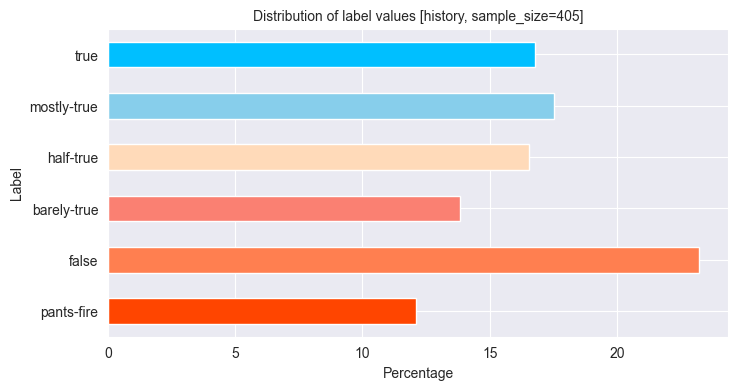

In [32]:
# create a bar chart over labels for a single subject. Store the returned dataframe to a variable.
sub_ret_df = subject_bar_chart(subject_df, 'history')

### Feature Engineering

#### Data Preprocessing

In [33]:
def preprocess_text(text):
    """
    Avoid over-preprocessing
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    return text.strip()

df_train['Processed_Statement'] = df_train['Statement'].apply(preprocess_text)

In [34]:
print(df_train['Processed_Statement'].iloc[:1].tolist())

['when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.']


In [35]:
# Concatenating Text Features
df_train['text'] = df_train['Speaker'] + ", " + df_train['Subject'] + ", " + df_train['Processed_Statement']

In [36]:
print(df_train['text'].iloc[:1].tolist())

['scott-surovell, energy,history,job-accomplishments, when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.']


#### Tokenization

In [37]:
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Applications/anaconda3/envs/ml/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Applications/anaconda3/envs/ml/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
# Tokenize the combined text
encoded_inputs = tokenizer(
    df_train['text'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# These tensors will model inputs
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [39]:
for i in range(2):
    # Decode the input_ids back to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[i])

    print(f"Example {i+1}:")
    print(f"Tokens: {tokens}")
    print(f"Input IDs: {input_ids[i].tolist()}")
    print(f"Attention Mask: {attention_masks[i].tolist()}")
    print("\n")

Example 1:
Tokens: ['[CLS]', 'scott', '-', 'sur', '##ove', '##ll', ',', 'energy', ',', 'history', ',', 'job', '-', 'accomplishments', ',', 'when', 'did', 'the', 'decline', 'of', 'coal', 'start', '?', 'it', 'started', 'when', 'natural', 'gas', 'took', 'off', 'that', 'started', 'to', 'begin', 'in', '(', 'president', 'george', 'w', '.', ')', 'bush', '##s', 'administration', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

So much number of [PAD] to make the input align the BERT pre-defined token length 512. All input sequences in a batch to have the same length.